In [ ]:
!pip install -q pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 39.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# # Change working directory
os.chdir('/content/drive/My Drive/NeuralCompression')

# # Verify the change
print("Current working directory:", os.getcwd())

Mounted at /content/drive
Current working directory: /content/drive/My Drive/NeuralCompression


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pytorch_lightning as pl

import numpy as np
import matplotlib.pyplot as plt

torch.set_float32_matmul_precision('medium')

In [ ]:
class PointDataset(Dataset):
    def __init__(self, data, num_batches=100, num_samples=10000):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.data = self.data / self.data.max()
        self.num_batches = num_batches
        self.num_samples = num_samples
        self.H, self.W, self.C = self.data.shape

        # Precompute indices and coordinates for efficiency
        self.precompute_indices_and_coordinates()

    def precompute_indices_and_coordinates(self):
        self.indices = []
        self.coordinates = []

        for _ in range(self.num_batches):
            indices = np.random.choice(self.H * self.W, self.num_samples, replace=False)
            indices_x = indices // self.W
            indices_y = indices % self.W
            coords = torch.tensor([indices_y / self.W, indices_x / self.H], dtype=torch.float32).T
            self.indices.append((indices_x, indices_y))
            self.coordinates.append(coords)

    def __len__(self):
        return self.num_batches

    def __getitem__(self, idx):
        indices_x, indices_y = self.indices[idx]
        coordinates = self.coordinates[idx]
        samples = self.data[indices_x, indices_y, :]
        return coordinates, samples

In [ ]:

from typing import Any


class NeuralFieldModel(pl.LightningModule):
    def __init__(self, input_dim, grid_sizes=[2,4,8,16,32,128], grid_feature_size=2, lr=1e-3):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(len(grid_sizes) * grid_feature_size * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )

        self.input_dim = input_dim
        self.grid_sizes = grid_sizes
        self.grid_feature_size = grid_feature_size
        self.lr = lr

        self.grid_x = nn.ParameterList([nn.Parameter(torch.randn(size, grid_feature_size) * 0.001) for size in grid_sizes])
        self.grid_y = nn.ParameterList([nn.Parameter(torch.randn(size, grid_feature_size) * 0.001) for size in grid_sizes])

    def linear_interpolate(self, grid, coords):
        # coords are assumed to be in range [0, 1]
        coords = coords * (grid.size(0) - 1)  # Scale to grid size
        left_idx = torch.floor(coords).long()
        right_idx = torch.ceil(coords).long()
        left_val = grid[left_idx]
        right_val = grid[right_idx]
        weight = coords - left_idx.float()
        interpolated_val = left_val * (1 - weight.unsqueeze(-1)) + right_val * weight.unsqueeze(-1)
        return interpolated_val

    def grid_encoding(self, x):
        # x is Bx2 coordinates in (0,1)
        B = x.size(0)
        features = []

        x_coords = x[:, 0]  # B
        y_coords = x[:, 1]  # B

        for grid_x, grid_y in zip(self.grid_x, self.grid_y):
            feature_x = self.linear_interpolate(grid_x, x_coords)  # BxC
            feature_y = self.linear_interpolate(grid_y, y_coords)  # BxC

            # Concatenate features from x and y at each level
            feature = torch.cat([feature_x, feature_y], dim=-1)  # Bx(2*C)
            features.append(feature)

        # Concatenate features from all levels
        features = torch.cat(features, dim=-1)  # Bx(2*C*L)
        return features

    def forward(self, x):
        x = self.grid_encoding(x)
        return self.model(x)

    def training_step(self, batch, batch_idx):

        coordinates, samples = batch[0].squeeze(0), batch[1].squeeze(0) # remove excess batch dimension
        predictions = self.forward(coordinates)

        loss = (predictions - samples)**2
        loss = loss.mean()

        self.log('train_loss', loss)

        if batch_idx == 0:
            print(f"Loss: {loss.item()}")

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)

        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
        return [optimizer], [scheduler]

torch.set_float32_matmul_precision('medium')

In [ ]:
def get_model_size_megabytes(model): # returns the size of the model in megabytes
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    total_size = param_size + buffer_size  # in bytes
    total_size_megabytes = total_size / (1024 ** 2)  # convert bytes to megabytes
    return total_size_megabytes

def get_image_size_megabytes(array): # returns the size of the image in megabytes
    total_size_bytes = array.nbytes / 8  # total size in bytes (64 -> 8)
    total_size_megabytes = total_size_bytes / (1024 ** 2)  # convert bytes to megabytes
    return total_size_megabytes


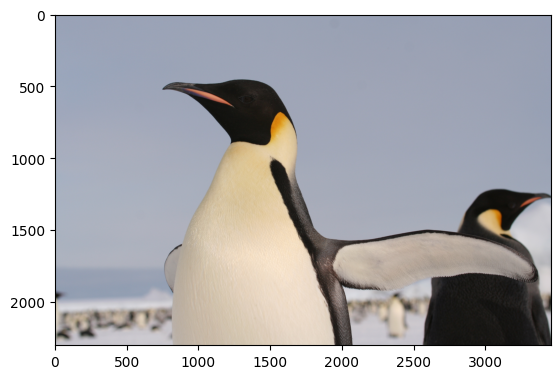

In [ ]:
img = plt.imread("emperorpenguin.jpg") / 255.0
factor = 1
srcimg = img[::factor,::factor]
plt.imshow(img)
plt.show()

In [ ]:
# import torch.nn as nn
# factor = 1/20
# img = srcimg[None]
# img = np.transpose(img, (0,3,1,2))
# img = torch.tensor(img)
# img = torch.nn.functional.interpolate(img, scale_factor = factor, mode = 'bilinear')
# img = img.squeeze().detach().cpu().numpy()
# img = np.transpose(img, (1,2,0))


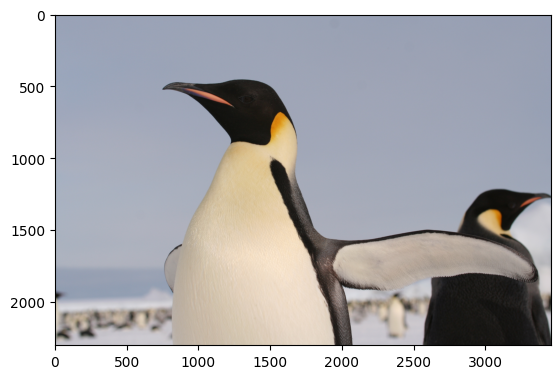

In [ ]:
plt.imshow(img)

In [ ]:
get_image_size_megabytes(img)


22.78125

In [ ]:
dataset = PointDataset(img, num_batches=30, num_samples=1000000) # intializes dataset and puts data into dataset a million samples (pixels), 10 batches per epoch
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, pin_memory=True, num_workers=2) # loads data into model; num_workers is # of helpers

/tmp/ipython-input-695291442.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  coords = torch.tensor([indices_y / self.W, indices_x / self.H], dtype=torch.float32).T


In [ ]:
model = NeuralFieldModel(input_dim = 2, lr=1e-2) #lr is your learning rate

In [ ]:
def get_model_size_megabytes(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    total_size = param_size + buffer_size  # in bytes
    total_size_megabytes = total_size / (1024 ** 2)  # convert bytes to megabytes
    return total_size_megabytes

def get_image_size_megabytes(array):
    total_size_bytes = array.nbytes / 8  # total size in bytes (64 -> 8)
    total_size_megabytes = total_size_bytes / (1024 ** 2)  # convert bytes to megabytes
    return total_size_megabytes


In [ ]:
trainer = pl.Trainer(max_epochs=40, accelerator="auto")
trainer.fit(model, dataloader)

SyntaxError: incomplete input (ipython-input-2828571807.py, line 1)

In [ ]:
# shorter wait
#trainer = pl.Trainer(max_epochs=2, accelerator="auto")
#trainer.fit(model, dataloader)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type          | Params | Mode 
-------------------------------------------------
0 | model  | Sequential    | 14.3 K | train
1 | grid_x | ParameterList | 380    | train
2 | grid_y | ParameterList | 380    | train
-------------------------------------------------
15.0 K    Trainable params
0         Non-trainable params
15.0 K    Total params
0.060     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval 

Training: |          | 0/? [00:00<?, ?it/s]

Loss: 0.444583922624588
Loss: 0.03558458760380745


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [ ]:

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def make_grid(H, W):
    # Create a grid of normalized coordinates
    y = np.linspace(0, 1, H)
    x = np.linspace(0, 1, W)
    grid_x, grid_y = np.meshgrid(x, y)
    coordinates = np.stack([grid_x.ravel(), grid_y.ravel()], axis=-1)
    coordinates = torch.tensor(coordinates, dtype=torch.float32)

    return coordinates

H, W = img.shape[0], img.shape[1]

coordinates = make_grid(H,W)
coordinates = coordinates.to(model.device)
reconstruction = model(coordinates)
reconstruction = reconstruction.reshape(H,W,3).detach().cpu().numpy()

plt.imshow(img)
plt.title("Original Image")
plt.show()

plt.imshow(reconstruction)
plt.title("Reconstructed Image")
plt.show()

print("PSNR: ", psnr(img, reconstruction, data_range=1)) #higher PSNR the better, measure of how similar the colors of reconstructed img to original img; 30-40 is this the actual color
print("SSIM: ", ssim(img, reconstruction, channel_axis=2, data_range=1)) #structural similarity; how close the structure is (whether or not edges in images are aligned or not; below 0.9 is bad; want it to be around 1)

In [ ]:
reconstruction = np.clip(reconstruction, 0 , 1)

In [ ]:
plt.imsave("brad_compress2.jpg", reconstruction)

In [ ]:
print("Image size: ", get_image_size_megabytes(img))
print("Model size: ", get_model_size_megabytes(model))
print("Compression Ratio:", get_image_size_megabytes(img) / get_model_size_megabytes(model))
